In [1]:
import warnings
warnings.filterwarnings("ignore")

import re
import fnmatch
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from matplotlib import pyplot as plt

from supervenn import supervenn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score, accuracy_score
from scipy.stats import kendalltau, spearmanr, pearsonr

from feature_extraction import (
    extract_question_features,
    extract_gold_solution_features,
    extract_unified_features
)

# Processing Response Data

### Load Responses

In [2]:
# Response data-frame: contains all questions from GSM8K and corresponding gold answers and LLM generated solutions 
#   - "question": Original question text from GSM8K
#   - "split": Dataset split from GSM8K ("train" or "test")
#   - "gold_solution": Original solution for question from GSM8K
#   - "auto_solution_<LLM>_<RESPONSE_IDX>": LLM response to corresponsind question prompt; 
#       - <LLM>: Unique label for each llm used
#       - <RESPONSE_IDX>: Index(0-4) to mark one of 5 responses queried per question per llm.

df = pd.read_json(open("../../data/response_datasets/gsm8k_responses.json",'r'), orient="records")
display(df)

question  \
0     Natalia sold clips to 48 of her friends in Apr...   
1     Weng earns $12 an hour for babysitting. Yester...   
2     Betty is saving money for a new wallet which c...   
3     Julie is reading a 120-page book. Yesterday, s...   
4     James writes a 3-page letter to 2 different fr...   
...                                                 ...   
8787  John had a son James when he was 19.  James is...   
8788  There are some oranges in a basket. Ana spends...   
8789  Mark's car breaks down and he needs to get a n...   
8790  Farmer Brown has 20 animals on his farm, all e...   
8791  Henry and 3 of his friends order 7 pizzas for ...   

                                          gold_solution  split  \
0     Natalia sold 48/2 = <<48/2=24>>24 clips in May...  train   
1     Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...  train   
2     In the beginning, Betty has only 100 / 2 = $<<...  train   
3     Maila read 12 x 2 = <<12*2=24>>24 pages today....  train   
4     He writes each friend 3*2=<<3*2=6>>6 pages a w...  train   
...                                                 ...    ...   
8787  Dora is 12-3=<<12-3=9>>9\nSo James is 9*2=<<9*...   test   
8788  There are 60 minutes in an hour. Ana peels an ...   test   
8789  The discount on the radiator was 400*.8=$<<400...   test   
8790  Let C be the number of chickens.\nThere are 20...   test   
8791  There are 7*8=<<7*8=56>>56 slices in total.\nT...   test   

                             auto_solution_llama2-13b_0  \
0       Sure! Let's analyze the information given:\n...   
1       Sure, I'd be happy to help!\n\nTo find out h...   
2       Sure, I'd be happy to help! Let's break this...   
3       Sure, I'd be happy to help! Let's break down...   
4       To find out how many pages James writes in a...   
...                                                 ...   
8787    Let's break down the information we have:\n\...   
8788    To solve this problem, we need to find out h...   
8789    Sure, I'd be happy to help! Here's the calcu...   
8790    Great question! Let's think about this one s...   
8791    Sure, I'd be happy to help!\n\nIf Henry and ...   

                             auto_solution_llama2-13b_1  \
0       Sure, I'd be happy to help!\n\nLet's say Nat...   
1       Sure, I'd be happy to help! To find out how ...   
2       Sure, I'd be happy to help! Let's work throu...   
3       Sure, I'd be happy to help! Let's break down...   
4       To find out how many pages James writes per ...   
...                                                 ...   
8787    Let's break down the information we know:\n\...   
8788    To solve this problem, we can use the concep...   
8789    Sure, I'd be happy to help you with that! He...   
8790    To solve this problem, we can use a systemat...   
8791    Sure! To solve this problem, we can use divi...   

                             auto_solution_llama2-13b_2  \
0       Sure, I'd be happy to help!\n\nLet's start b...   
1       Sure, I'd be happy to help! To find out how ...   
2       Sure, I'd be happy to help! Let's break down...   
3       Sure, I'd be happy to help! Let's break this...   
4       To solve this problem, we need to calculate ...   
...                                                 ...   
8787    Let's start by identifying the information w...   
8788    Sure, I'd be happy to help! Let's analyze th...   
8789    Sure, I'd be happy to help! Here's the calcu...   
8790    To solve this problem, we can use a simple p...   
8791    Sure, I'd be happy to help!\n\nTo find out h...   

                             auto_solution_llama2-13b_3  \
0       Sure, I'd be happy to help! Let's break down...   
1       Sure, I'd be happy to help!\n\nTo find out h...   
2       Sure, I'd be happy to help! Let's break down...   
3       Sure, I'd be happy to help! Let's break down...   
4       To calculate the number of pages James write...   
...                                                 ...   
8787 

In [3]:
# Ordered list of LLMs present in response data
LLMS = list(sorted(set([c.split('_')[2] for c in df.columns if fnmatch.fnmatchcase(str(c), f"auto_solution_*_*")])))
pprint(LLMS)

['llama2-13b', 'llama2-70b', 'metamath-13b', 'mistral-7b']


### Extract Final Answers

In [4]:
def get_final_auto_ans(text):
    primary_candidates = re.findall(r'=[ ]*[\£\€\$\-]*\d+(?:[,\.\/]+\d+)?',text)
    if primary_candidates:
        if '/' in primary_candidates[-1]:
            primary_candidates[-1] = re.sub(r'[^0-9\-\/]','',primary_candidates[-1])
            numerator, denominator = primary_candidates[-1].split('/')
            primary_candidates[-1] = str(float(numerator.strip()) / float(denominator.strip()))
        return float(re.sub(r'[^0-9\.\-]','',primary_candidates[-1].strip()))
    else: 
        secondary_candidates = re.findall(r'[\£\€\$\-]*\d+(?:[,\.\/]+\d+)?',text)
        if secondary_candidates:
            if '/' in secondary_candidates[-1]:
                secondary_candidates[-1] = re.sub(r'[^0-9\-\/]','',secondary_candidates[-1])
                numerator, denominator = secondary_candidates[-1].split('/')
                secondary_candidates[-1] = str(float(numerator.strip()) / float(denominator.strip()))
            return float(re.sub(r'[^0-9\.\-]','',secondary_candidates[-1].strip()))
        else:
            return "INVALID"
    
def get_final_gold_ans(text):
    return float(re.sub(r'[^0-9\.]+','',text.split("####")[-1]).strip())

def matches(a1,a2,eps=1e-1):
    if isinstance(a1,str) or isinstance(a2,str):
        return 0 
    return 1.0 if abs(a1-a2) < eps else 0.0

for llm in LLMS:
    for i in range(5):
        df[f"auto_answer_{llm}_{i}"] = [get_final_auto_ans(str(a)) for a in df[f"auto_solution_{llm}_{i}"]]
        df[f"auto_verdict_{llm}_{i}"] = [matches(a,get_final_gold_ans(str(g))) for a,g in zip(df[f"auto_answer_{llm}_{i}"],df["gold_solution"])]

display(df)

question  \
0     Natalia sold clips to 48 of her friends in Apr...   
1     Weng earns $12 an hour for babysitting. Yester...   
2     Betty is saving money for a new wallet which c...   
3     Julie is reading a 120-page book. Yesterday, s...   
4     James writes a 3-page letter to 2 different fr...   
...                                                 ...   
8787  John had a son James when he was 19.  James is...   
8788  There are some oranges in a basket. Ana spends...   
8789  Mark's car breaks down and he needs to get a n...   
8790  Farmer Brown has 20 animals on his farm, all e...   
8791  Henry and 3 of his friends order 7 pizzas for ...   

                                          gold_solution  split  \
0     Natalia sold 48/2 = <<48/2=24>>24 clips in May...  train   
1     Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...  train   
2     In the beginning, Betty has only 100 / 2 = $<<...  train   
3     Maila read 12 x 2 = <<12*2=24>>24 pages today....  train   
4     He writes each friend 3*2=<<3*2=6>>6 pages a w...  train   
...                                                 ...    ...   
8787  Dora is 12-3=<<12-3=9>>9\nSo James is 9*2=<<9*...   test   
8788  There are 60 minutes in an hour. Ana peels an ...   test   
8789  The discount on the radiator was 400*.8=$<<400...   test   
8790  Let C be the number of chickens.\nThere are 20...   test   
8791  There are 7*8=<<7*8=56>>56 slices in total.\nT...   test   

                             auto_solution_llama2-13b_0  \
0       Sure! Let's analyze the information given:\n...   
1       Sure, I'd be happy to help!\n\nTo find out h...   
2       Sure, I'd be happy to help! Let's break this...   
3       Sure, I'd be happy to help! Let's break down...   
4       To find out how many pages James writes in a...   
...                                                 ...   
8787    Let's break down the information we have:\n\...   
8788    To solve this problem, we need to find out h...   
8789    Sure, I'd be happy to help! Here's the calcu...   
8790    Great question! Let's think about this one s...   
8791    Sure, I'd be happy to help!\n\nIf Henry and ...   

                             auto_solution_llama2-13b_1  \
0       Sure, I'd be happy to help!\n\nLet's say Nat...   
1       Sure, I'd be happy to help! To find out how ...   
2       Sure, I'd be happy to help! Let's work throu...   
3       Sure, I'd be happy to help! Let's break down...   
4       To find out how many pages James writes per ...   
...                                                 ...   
8787    Let's break down the information we know:\n\...   
8788    To solve this problem, we can use the concep...   
8789    Sure, I'd be happy to help you with that! He...   
8790    To solve this problem, we can use a systemat...   
8791    Sure! To solve this problem, we can use divi...   

                             auto_solution_llama2-13b_2  \
0       Sure, I'd be happy to help!\n\nLet's start b...   
1       Sure, I'd be happy to help! To find out how ...   
2       Sure, I'd be happy to help! Let's break down...   
3       Sure, I'd be happy to help! Let's break this...   
4       To solve this problem, we need to calculate ...   
...                                                 ...   
8787    Let's start by identifying the information w...   
8788    Sure, I'd be happy to help! Let's analyze th...   
8789    Sure, I'd be happy to help! Here's the calcu...   
8790    To solve this problem, we can use a simple p...   
8791    Sure, I'd be happy to help!\n\nTo find out h...   

                             auto_solution_llama2-13b_3  \
0       Sure, I'd be happy to help! Let's break down...   
1       Sure, I'd be happy to help!\n\nTo find out h...   
2       Sure, I'd be happy to help! Let's break down...   
3       Sure, I'd be happy to help! Let's break down...   
4       To calculate the number of pages James write...   
...                                                 ...   
8787 

### Calculate Success Rates

In [5]:
for llm in LLMS:
    df[f"sr_{llm}"] = df[[c for c in df.columns if fnmatch.fnmatchcase(str(c), f"auto_verdict_{llm}_*")]].mean(axis=1)
df[f"sr_intersection"] = df[[c for c in df.columns if fnmatch.fnmatchcase(str(c), f"auto_verdict_*_*")]].mean(axis=1)

In [6]:
# Mean Success Rates
tab_df = []
for llm_set in LLMS + ["intersection"]:
    tab_df.append({
        "LLM Set": llm_set,
        "Success Rate Mean": round(df[f"sr_{llm_set}"].mean(),4),
        "Success Rate Standard Deviation": round(df[f"sr_{llm_set}"].std(),4),
    })
tab_df = pd.DataFrame(tab_df)
display(tab_df)

LLM Set  Success Rate Mean  Success Rate Standard Deviation
0    llama2-13b             0.3840                           0.3698
1    llama2-70b             0.5675                           0.3919
2  metamath-13b             0.8371                           0.2843
3    mistral-7b             0.3695                           0.3396
4  intersection             0.5395                           0.2706

### Success Rate Distribution Among LLMs 

In [7]:
tab_df = []
for split in ["train","test"]:

    row = {"Split":split, "Class": "Always"}
    # Always Correct
    for llm in LLMS + ["intersection"]:
        subdf = df[(df["split"]==split) & (df[f"sr_{llm}"].isin([0.0,1.0]))]
        subset_len = len(subdf[subdf[f"sr_{llm}"]==1.0])
        row[llm] = f"{subset_len} ({round(100 * subset_len / len(subdf),2)}%)"
    tab_df.append(row)

    row = {"Split":split, "Class": "Never"}
    # Always Correct
    for llm in LLMS + ["intersection"]:
        subdf = df[(df["split"]==split) & (df[f"sr_{llm}"].isin([0.0,1.0]))]
        subset_len = len(subdf[subdf[f"sr_{llm}"]==0.0])
        row[llm] = f"{subset_len} ({round(100 * subset_len / len(subdf),2)}%)"
    tab_df.append(row)

    row = {"Split":split, "Class": "Always"}
    # Total
    for llm in LLMS + ["intersection"]:
        subdf = df[(df["split"]==split) & (df[f"sr_{llm}"].isin([0.0,1.0]))]
        row[llm] = f"{len(subdf)}"
    tab_df.append(row)

tab_df = pd.DataFrame(tab_df)
tab_df

Split   Class     llama2-13b     llama2-70b  metamath-13b     mistral-7b  \
0  train  Always  1102 (30.22%)  2438 (61.36%)  5162 (94.7%)   733 (24.06%)   
1  train   Never  2545 (69.78%)  1535 (38.64%)    289 (5.3%)  2313 (75.94%)   
2  train  Always           3647           3973          5451           3046   
3   test  Always   188 (28.14%)   427 (60.06%)  528 (71.64%)   111 (21.51%)   
4   test   Never   480 (71.86%)   284 (39.94%)  209 (28.36%)   405 (78.49%)   
5   test  Always            668            711           737            516   

   intersection  
0  214 (53.37%)  
1  187 (46.63%)  
2           401  
3   41 (30.37%)  
4   94 (69.63%)  
5           135

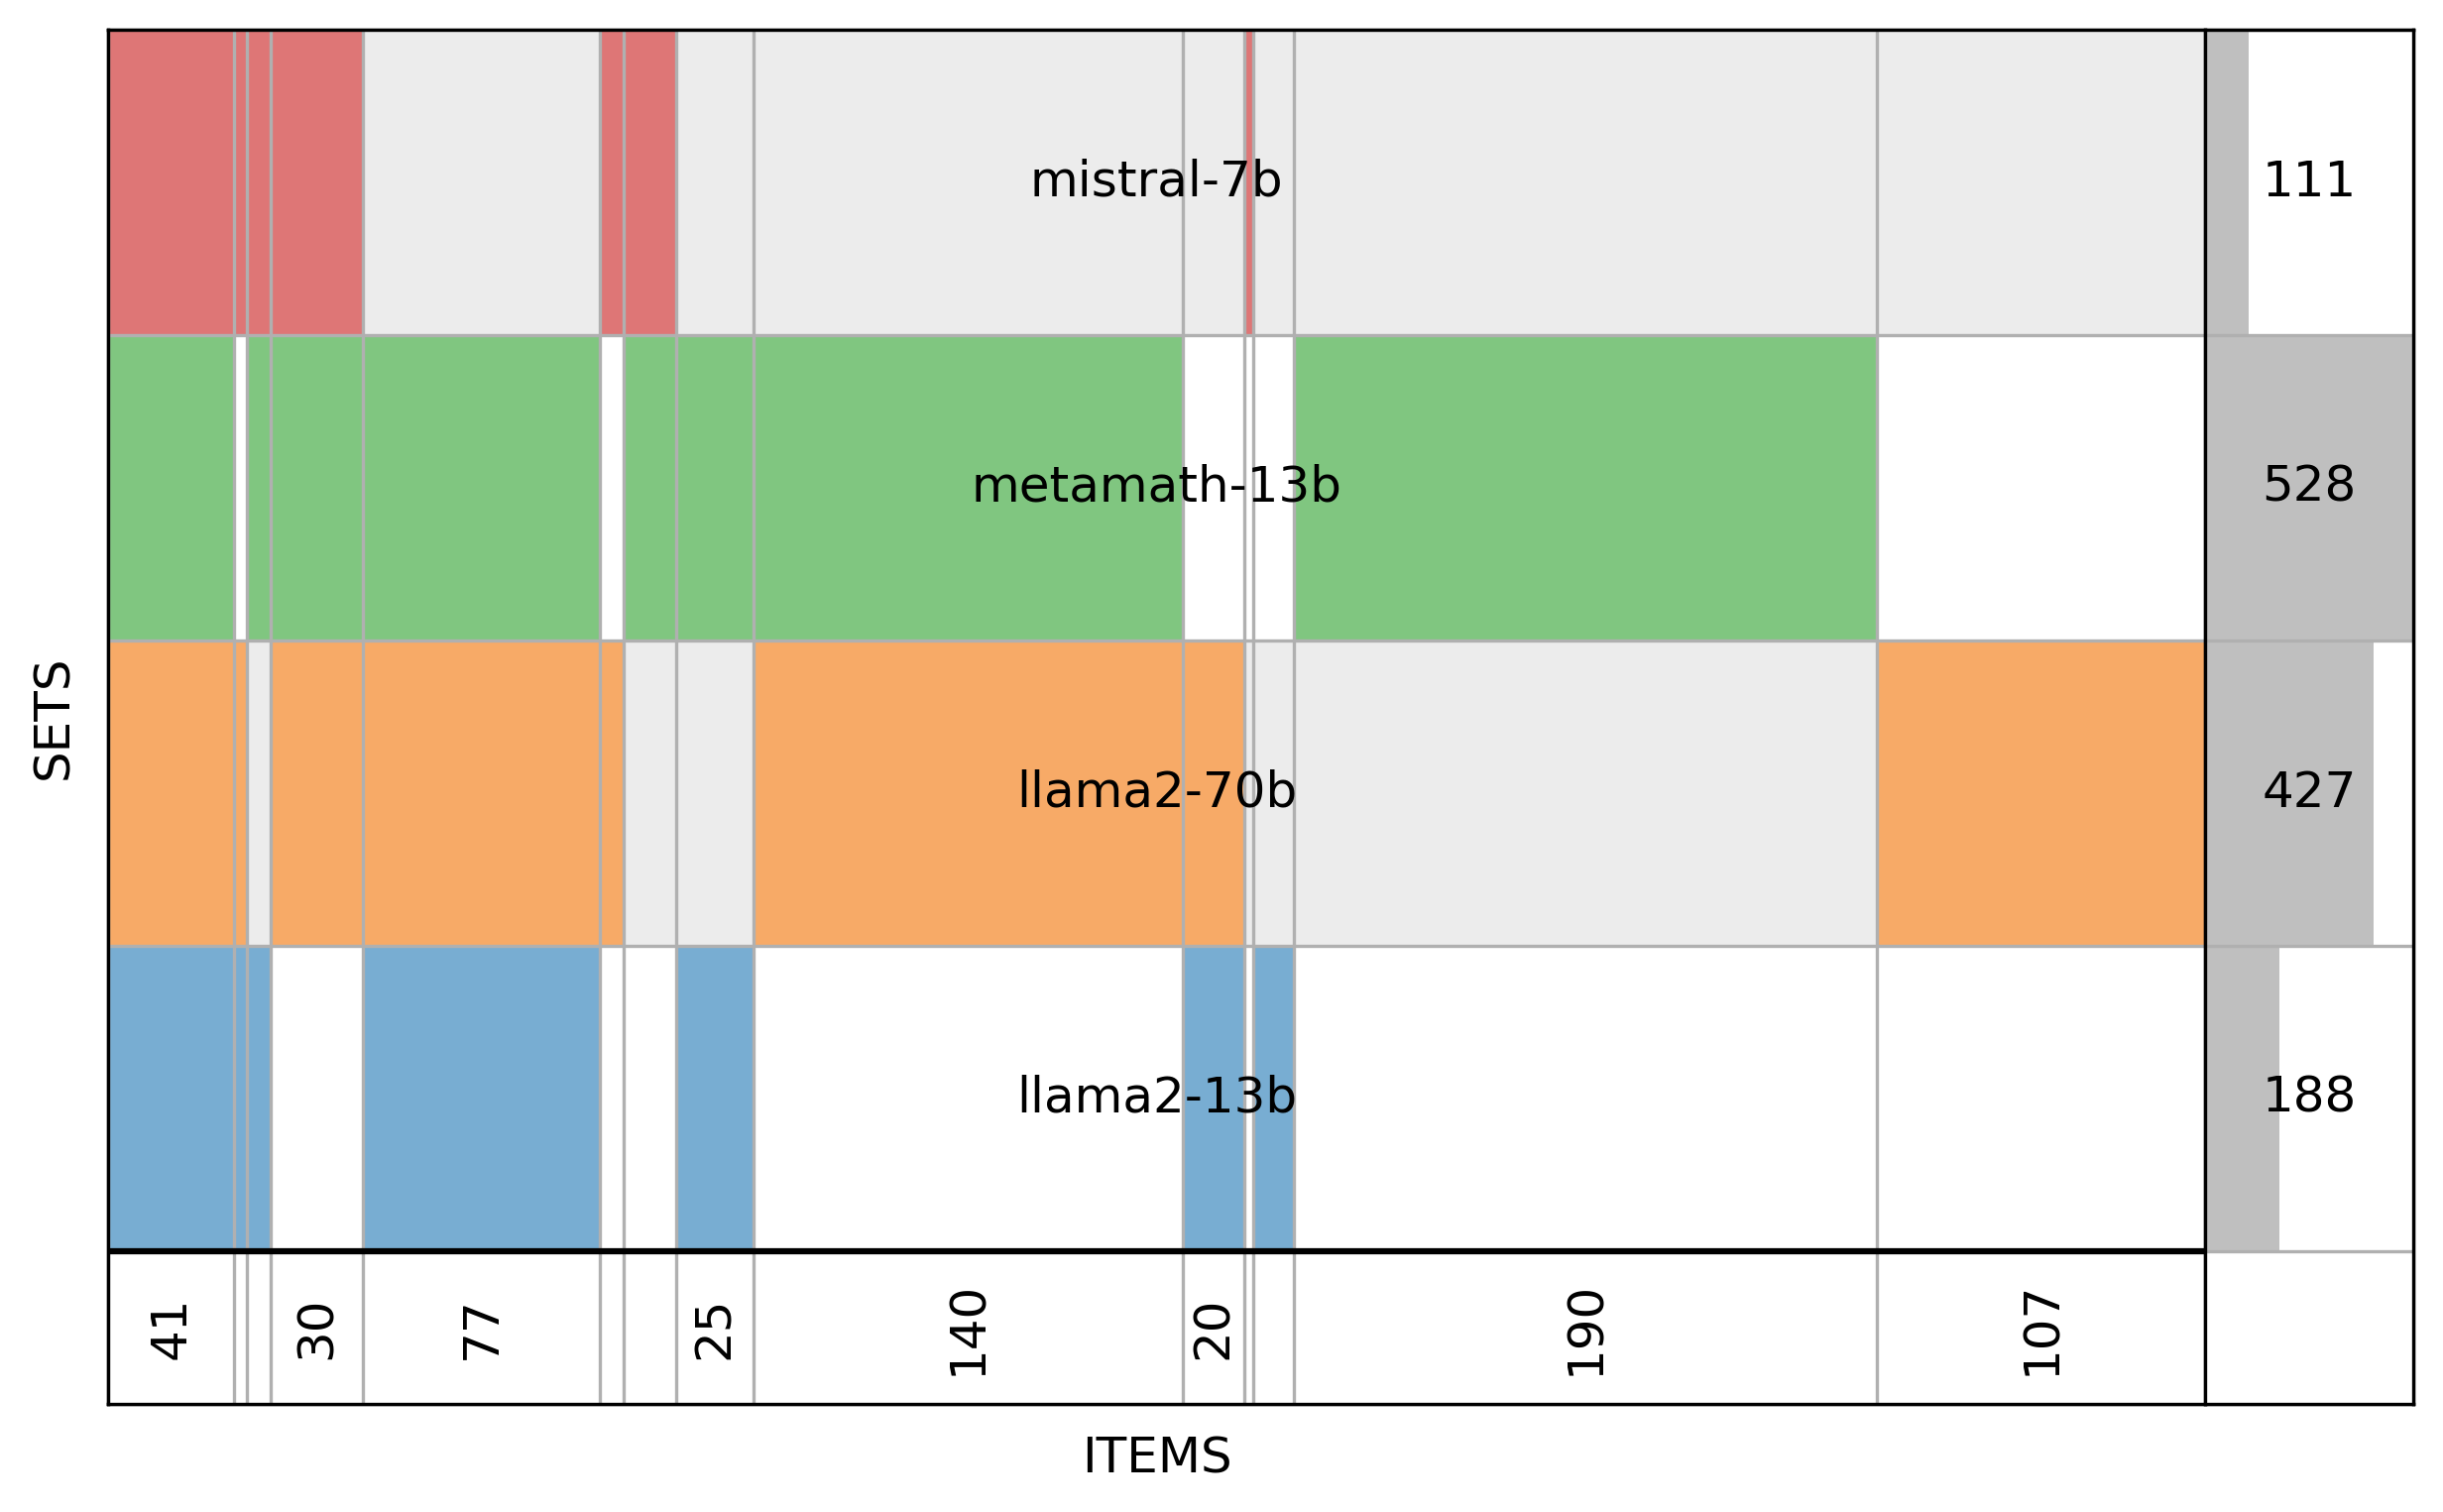

In [8]:
# Distribution of questions ALWAYS answered correctly from GSM8K test-set

pdf = df[df["split"]=="test"][[f"sr_{c}" for c in LLMS]]
sets = [set([vidx for vidx, v in enumerate(pdf[c]==1.0) if v==True]) for c in pdf.columns]
labels = LLMS.copy()

plt.figure(figsize=(10, 6), dpi=300)
supervenn(
    sets, labels, 
    chunks_ordering='occurence', 
    sets_ordering=None, 
    rotate_col_annotations=True,
    min_width_for_annotation=20,
    side_plots='right',
    side_plot_width=0.7
)
_ = plt.plot()

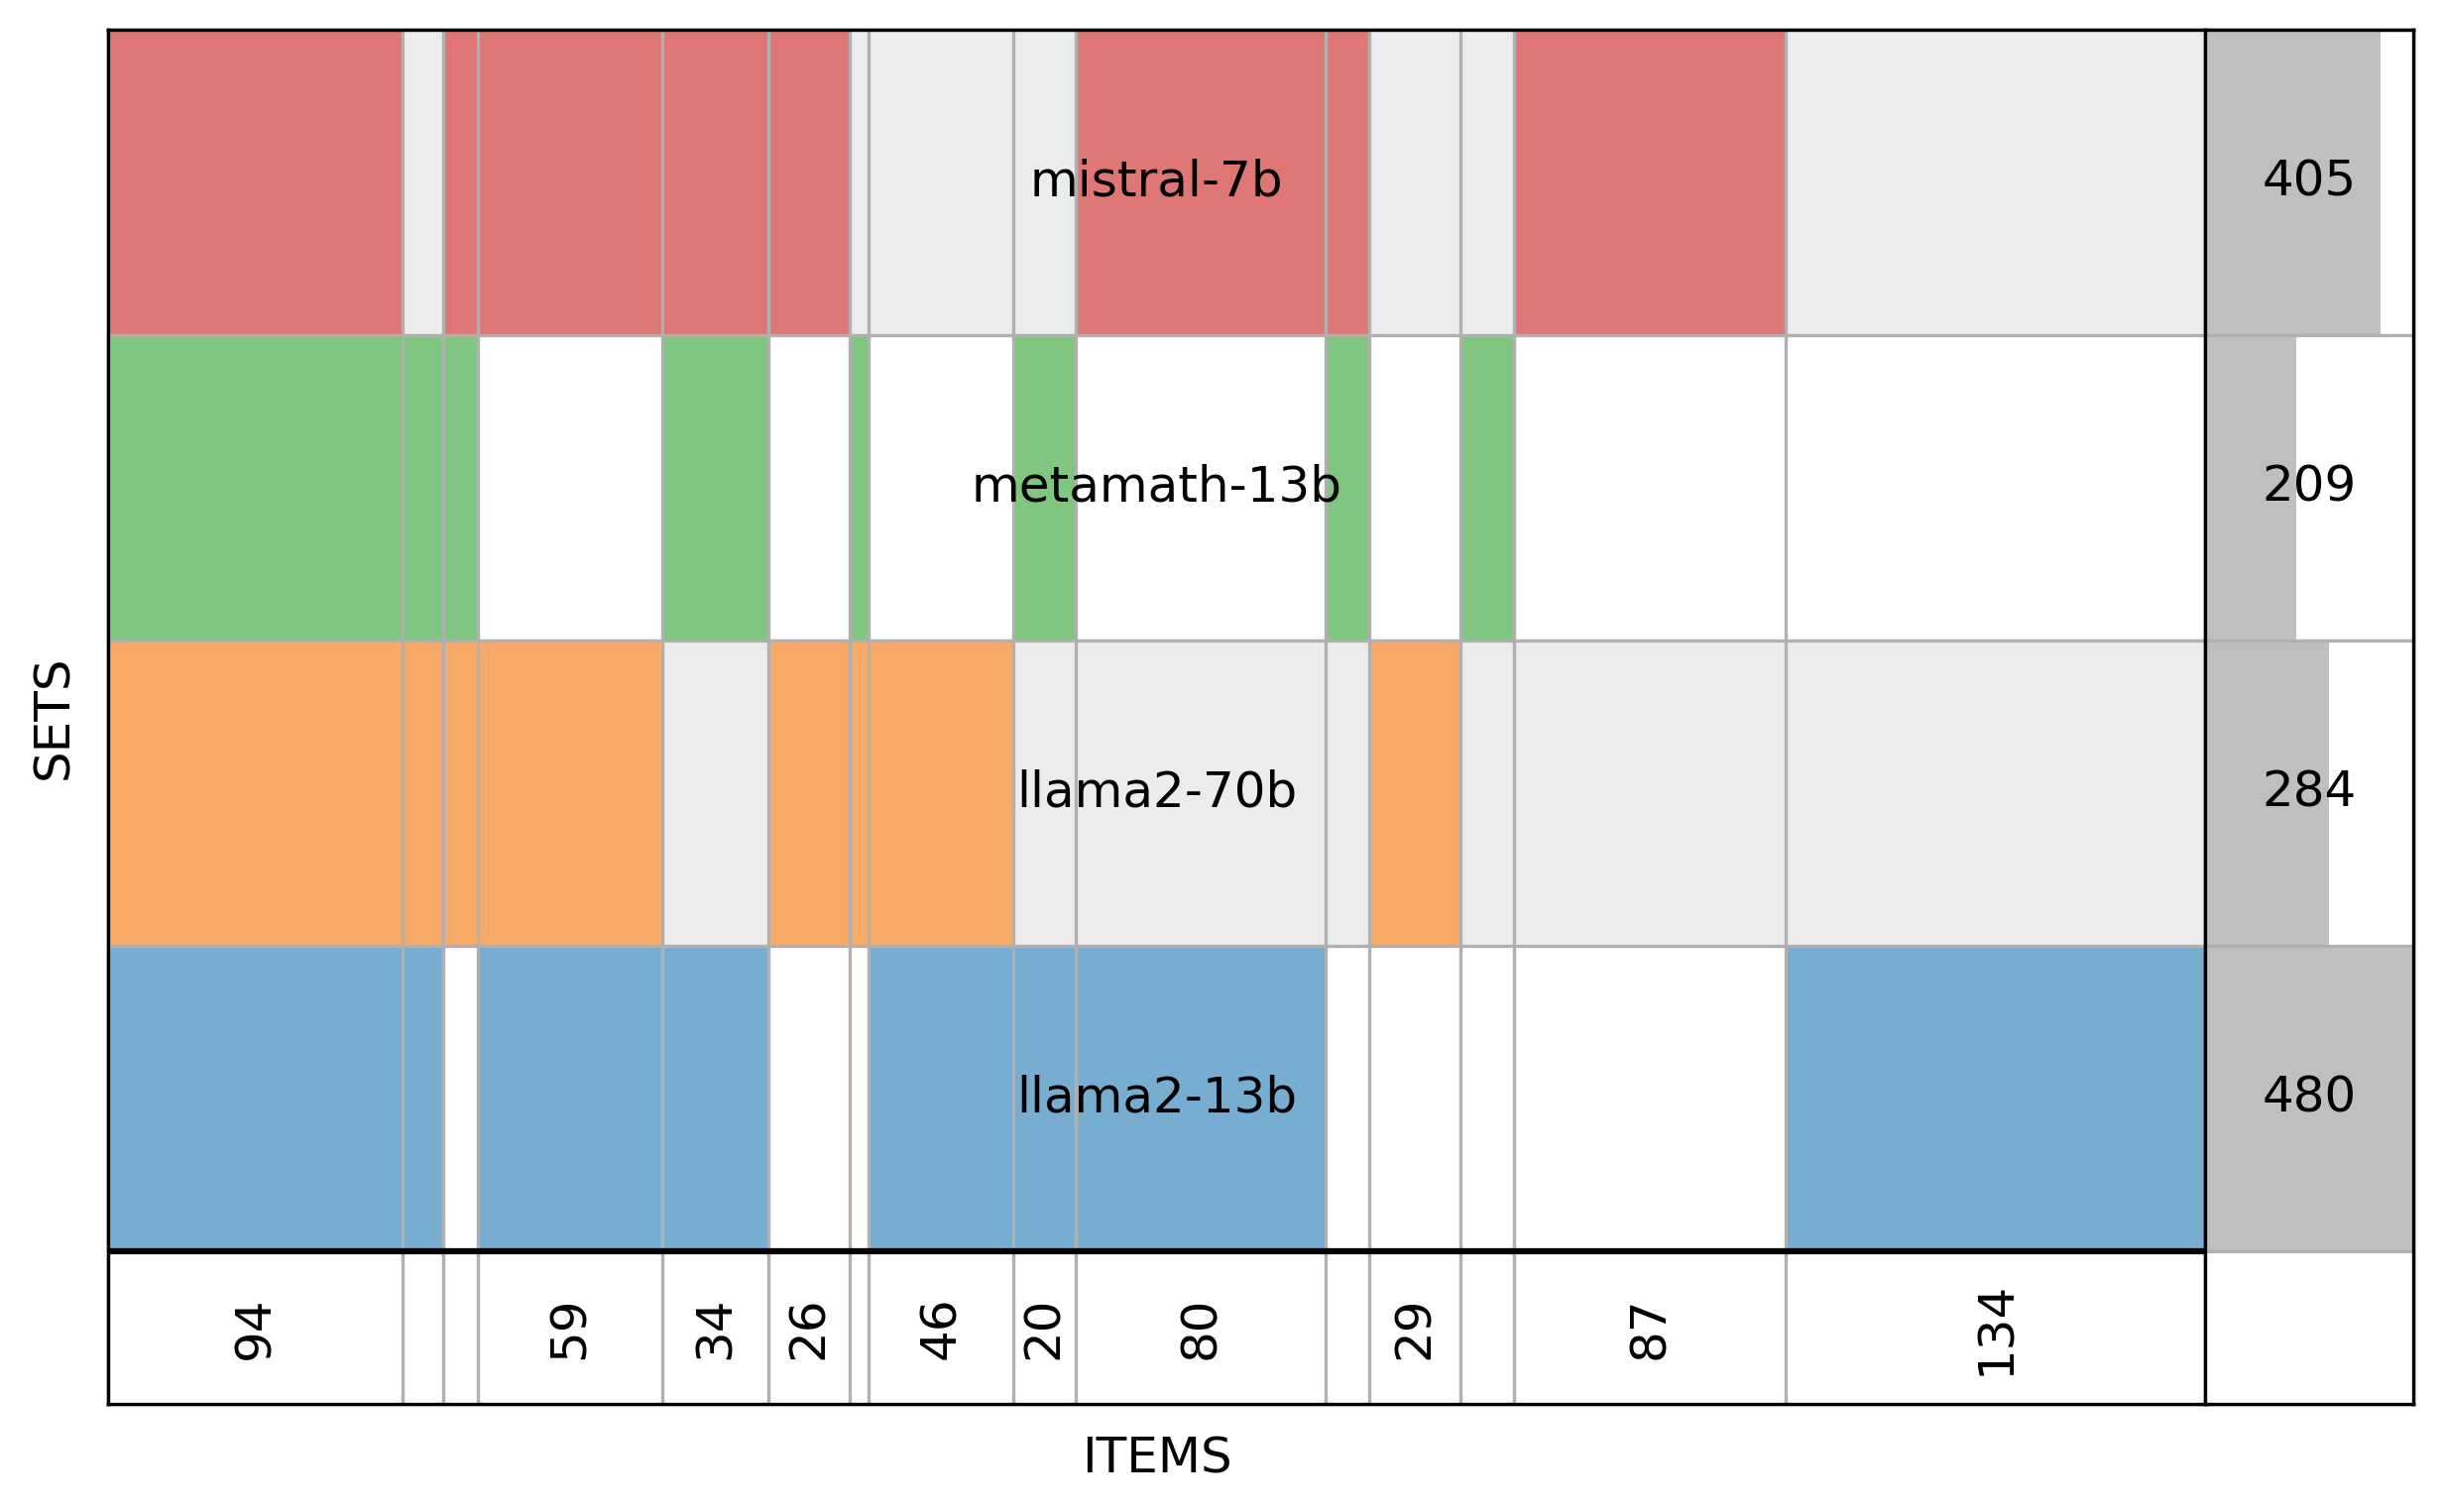

In [9]:
# Distribution of questions NEVER answered correctly from GSM8K test-set

pdf = df[df["split"]=="test"][[f"sr_{c}" for c in LLMS]]
sets = [set([vidx for vidx, v in enumerate(pdf[c]==0.0) if v==True]) for c in pdf.columns]
labels = LLMS.copy()

plt.figure(figsize=(10, 6), dpi=300)
supervenn(
    sets, labels, 
    chunks_ordering='occurence', 
    sets_ordering=None, 
    rotate_col_annotations=True,
    min_width_for_annotation=20,
    side_plots='right',
    side_plot_width=0.7
)
_ = plt.plot()

## Feature Extraction

In [10]:
# Build features

ques = df["question"]
gsols = df["gold_solution"]
parse_and_ner_data = pickle.load(open("../../data/feature_datasets/gsm8k_parse_ner_data.pkl",'rb'))

features = {}

features.update(extract_question_features(ques, parse_and_ner_data))
features.update(extract_gold_solution_features(gsols))
features.update(extract_unified_features(ques,gsols))

feature_df = pd.DataFrame(features)
FEATURE_COLUMNS = [c for c in feature_df if any([c.startswith(pre) for pre in ['Qx','Gx']])]

multi_np_count(): 100%|██████████| 8792/8792 [00:01<00:00, 4409.38it/s]
extract_question_features(): 13it [00:31,  2.45s/it]
max_numerical_word_rank(): 100%|██████████| 8792/8792 [00:01<00:00, 5107.63it/s]
extract_gold_solution_features(): 9it [00:03,  2.44it/s]
num_expression_feat(): 100%|██████████| 8792/8792 [00:00<00:00, 212212.17it/s]
extract_unified_features(): 1it [00:00,  2.83it/s]


In [11]:
display(feature_df)

Qx_token_length  Qx_sentence_length  Qx_word_length  Qx_arg_count  \
0                  41                   2              31             2   
1                  38                   3              20             2   
2                  64                   4              50             6   
3                  57                   3              41             3   
4                  27                   2              21             2   
...               ...                 ...             ...           ...   
8787               63                   3              45             5   
8788               67                   3              51             2   
8789               81                   4              61             4   
8790               44                   3              29             2   
8791               52                   3              37             3   

      Qx_num_arg_count  Qx_word_arg_count  Qx_flesch_reading_ease  \
0                    1                  1                   89.58   
1                    2                  0                   90.05   
2                    2                  4                   84.17   
3                    2                  1                   82.95   
4                    2                  0                   95.17   
...                ...                ...                     ...   
8787                 5                  0                  107.72   
8788                 2                  0                   88.06   
8789                 4                  0                   90.60   
8790                 2                  0                   87.01   
8791                 3                  0                   92.83   

      Qx_flesch_kinkaid_grade  Qx_mean_word_rank  Qx_mean_numerical_word_rank  \
0                         4.6        8484.536585                 18178.400000   
1                         2.4        9563.578947                 20154.000000   
2                         4.6        9109.750000                 21924.090909   
3                         5.1       10446.859649                 21124.300000   
4                         2.5       11412.333333                 20119.500000   
...                       ...                ...                          ...   
8787                      1.8       12130.571429                 26233.000000   
8788                      5.2        7955.880597                 22638.625000   
8789                      4.2        9346.654321                 24777.176471   
8790                      3.5       10091.159091                 20155.555556   
8791                      3.4        9218.596154                 20161.444444   

      ...  Gx_op'+'_count  Gx_op'-'_count  Gx_op'*'_count  Gx_op'/'_count  \
0     ...               1               0               0               1   
1     ...               0               0               1               1   
2     ...               0               3               1               1   
3     ...               1               1               1               1   
4     ...               0               0               3               0   
...   ...             ...             ...             ...             ...   
8787  ...               2               2               1               0   
8788  ...               0               1               0               2   
8789  ...               1               1               2               0   
8790  ...               0               0               0               0   
8791  ...               1               0               1               1   

      Gx_op'('_count  Gx_op_unique_count  Gx_op_diversity  \
0                  0                   2         1.000000   
1                  0                   2         1.000000   
2                  0                   3         0.666667   
3                  0                   4         1.000000   
4                  0                   1         0.500000   
...         

In [12]:
df = pd.concat((df,feature_df),axis=1)
df.to_json("../../data/feature_datasets/gsm8k_responses_and_features.json",index=False,indent=3,orient="records")

### Distribution of Features (Range, Mean, Std)

In [13]:
stats = []
# Iterate over each column in the DataFrame
for col in FEATURE_COLUMNS:
    # Compute the range, mean, and standard deviation for each column
    feat_range = (round(df[col].min(),3), round(df[col].max(),3))
    feat_mean = df[col].mean()
    feat_std = df[col].std()
    
    stats.append({'feature': col, 'range': feat_range, 'mean': feat_mean, 'std': feat_std})

tab_df = pd.DataFrame(stats)
display(tab_df)

feature                  range          mean  \
0               Qx_token_length              (12, 239)     66.049591   
1            Qx_sentence_length                (1, 13)      3.430505   
2                Qx_word_length               (9, 184)     45.884554   
3                  Qx_arg_count                (0, 17)      4.438353   
4              Qx_num_arg_count                (0, 15)      3.347247   
5             Qx_word_arg_count                (0, 14)      1.091106   
6        Qx_flesch_reading_ease        (25.96, 116.96)     88.594628   
7       Qx_flesch_kinkaid_grade           (-1.9, 26.3)      4.236454   
8             Qx_mean_word_rank  (3661.957, 21929.964)  10646.614821   
9   Qx_mean_numerical_word_rank     (259.0, 29905.375)  22643.318643   
10   Qx_constituency_tree_depth                (5, 31)     10.802889   
11                  Qx_np_count                (3, 74)     18.034236   
12                 Qx_prp_count                (0, 16)      1.771611   
13           Qx_unique_np_count                (0, 12)      3.427207   
14            Qx_multi_np_count                (0, 16)      0.461670   
15                 Gx_arg_count                (6, 73)     24.377275   
16             Gx_num_arg_count                (6, 71)     23.737716   
17            Gx_word_arg_count                (0, 20)      0.639559   
18               Gx_op'+'_count                (0, 12)      1.059713   
19               Gx_op'-'_count                 (0, 6)      0.601115   
20               Gx_op'*'_count                 (0, 8)      1.369313   
21               Gx_op'/'_count                 (0, 7)      0.620905   
22               Gx_op'('_count                 (0, 4)      0.025591   
23           Gx_op_unique_count                 (0, 6)      2.283553   
24              Gx_op_diversity           (0.154, 1.0)      0.757679   
25  Gx_mean_numerical_word_rank     (22645.0, 29915.0)  28626.040304   
26           Gx_parameter_usage           (0.067, 1.0)      0.642279   
27           Gx_world_knowledge                 (0, 8)      1.104186   

            std  
0     24.384020  
1      1.200971  
2     17.831769  
3      1.940433  
4      1.726784  
5      1.396895  
6     11.575248  
7      2.468064  
8   2110.890886  
9   3260.090483  
10     2.798496  
11     7.487727  
12     1.853998  
13     1.373134  
14     1.283103  
15     9.732187  
16     9.407261  
17     1.279537  
18     1.212195  
19     0.780121  
20     1.182949  
21     0.788920  
22     0.186948  
23     0.930414  
24     0.195980  
25   776.729889  
26     0.241298  
27     1.006325

### Correlation Between Features

In [14]:
# Feature Correlation

def pvalue_map(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

def corr_matrix_with_pval(df, method = 'pearson', figsize=(30, 15), title=None):
    
    # Make a copy of the df
    data = df.copy()
    # Set correlation method and generate values
    corr = data.corr(method = method)

    # Create a mask to hide the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set the diagonal elements of the mask to False to display self-correlation
    np.fill_diagonal(mask, False)

    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title, fontsize=14)

    # Create the heatmap with the custom mask
    heatmap = sns.heatmap(corr,
                            annot=True,
                            annot_kws={"fontsize": 10},  # Adjust annotation font size
                            fmt='.2f',
                            linewidths=0.5,
                            cmap='coolwarm',
                            mask=mask,
                            ax=ax)

    # Create a function to calculate and format p-values
    p_values = np.full((corr.shape[0], corr.shape[1]), np.nan)
    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[1]):
            x = data.iloc[:, i]
            y = data.iloc[:, j]
            mask = ~np.logical_or(np.isnan(x), np.isnan(y))
            if np.sum(mask) > 0:
                if method == 'pearson':
                    p_values[i, j] = pearsonr(x[mask], y[mask])[1] #Changes based on the method chosen in the function
                elif method == 'kendall':
                    p_values[i, j] = kendalltau(x[mask], y[mask])[1]
                elif method == 'spearman':
                    p_values[i, j] = spearmanr(x[mask], y[mask])[1]

    p_values = pd.DataFrame(p_values, columns=corr.columns, index=corr.index)

    # Create a mask for the p-values heatmap
    mask_pvalues = np.triu(np.ones_like(p_values), k=1)

    # Calculate the highest and lowest correlation coefficients
    max_corr = np.max(corr.max())
    min_corr = np.min(corr.min())

    # Annotate the heatmap with p-values and change text color based on correlation value
    for i in range(p_values.shape[0]):
        for j in range(p_values.shape[1]):
            if mask_pvalues[i, j]:
                p_value = p_values.iloc[i, j]
                if not np.isnan(p_value):
                    correlation_value = corr.iloc[i, j]
                    text_color = 'white' if correlation_value >= (max_corr - 0.4) or correlation_value <= (min_corr + 0.4) else 'black'
                    ax.text(i + 0.5, j + 0.8, pvalue_map(p_value),
                            horizontalalignment='center',
                            verticalalignment='center',
                            fontsize=8,
                            color=text_color)

    # Customize x-axis labels
    x_labels = [label.get_text() for label in ax.get_xticklabels()]
    ax.set_xticklabels(x_labels, rotation=45, ha="right")

    # Customize y-axis labels
    y_labels = [label.get_text() for label in ax.get_yticklabels()]
    ax.set_yticklabels(y_labels, rotation=0, ha="right")
    fig.set_dpi(400)
    plt.show()

corr_matrix_with_pval(df[FEATURE_COLUMNS])

# Success Rate Prediction

In [15]:
def prune_columns(df, FEATURE_COLUMNS, threshold=0.6, verbose=False):
    exclude_list = []
    corr = df[[f for f in FEATURE_COLUMNS if f not in exclude_list]].corr(method='spearman').abs()
    for i in range(len(corr.columns)):
        corr.iloc[i][i] = 0
    corr[corr <= threshold] = 0
    while corr.max(axis=1)[corr.max(axis=1).argmax()] != 0:
        exclude_list.append(corr.columns[corr.max(axis=1).argmax()])
        corr = df[[f for f in FEATURE_COLUMNS if f not in exclude_list]].corr(method='spearman').abs()
        for i in range(len(corr.columns)):
            corr.iloc[i][i] = 0
        corr[corr <= threshold] = 0
    if verbose:
        print(exclude_list)
    return df[[f for f in FEATURE_COLUMNS if f not in exclude_list]], [f for f in FEATURE_COLUMNS if f not in exclude_list]

### Accuracy and Macro-F1 Scores

In [16]:
tab_df = []
for cl_model in ["Logistic Regression", "Decision Tree", "Random Forest"]:
    row = {"Classifier Model": cl_model}
    for llm_set in LLMS + ["intersection"]:

        train_df = df[df["split"]=="train"]
        test_df = df[df["split"]=="test"]

        X_train = train_df[FEATURE_COLUMNS].copy()
        y_train = train_df[[c for c in train_df.columns if fnmatch.fnmatchcase(str(c), f"auto_verdict_{'*' if llm_set=='intersection' else llm_set}*")]].mean(axis=1)

        X_test = test_df[FEATURE_COLUMNS].copy()
        y_test = test_df[[c for c in test_df.columns if fnmatch.fnmatchcase(str(c), f"auto_verdict_{'*' if llm_set=='intersection' else llm_set}*")]].mean(axis=1)

        X_train['y'] = y_train
        X_train = X_train[(X_train['y']==0.0) | (X_train['y']==1.0)]
        X_train, y_train = X_train[FEATURE_COLUMNS], X_train['y']
        y_train = y_train > 0.5 

        X_test['y'] = y_test
        X_test = X_test[(X_test['y']==0.0) | (X_test['y']==1.0)]
        X_test, y_test = X_test[FEATURE_COLUMNS], X_test['y']
        y_test = y_test > 0.5

        X_train, feats = prune_columns(X_train,FEATURE_COLUMNS,threshold=0.7)
        X_test = X_test[feats]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        def oversample_dataset(X, y):
            oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
            X_resampled, y_resampled = oversampler.fit_resample(X, y)
            return X_resampled, y_resampled
        X_train, y_train = oversample_dataset(X_train, y_train)

        cls = None
        if cl_model == "Logistic Regression":
            clf = LogisticRegression().fit(X_train, y_train)
        elif cl_model == "Decision Tree":
            clf = DecisionTreeClassifier(max_leaf_nodes=100).fit(X_train, y_train)
        elif cl_model == "Random Forest":
            clf = RandomForestClassifier(max_depth=10, n_estimators=200, max_features=0.8).fit(X_train, y_train)
        else:
            raise Exception()

        pred_train = clf.predict(X_train)
        pred_test = clf.predict(X_test)

        acc = accuracy_score(y_test,pred_test)
        row[f"{llm_set}_Accuracy"] = round(acc,4)

        f1 = f1_score(y_test,pred_test,average='macro')
        row[f"{llm_set}_Macro-F1"] = round(f1,4)

    tab_df.append(row)

tab_df = pd.DataFrame(tab_df)
display(tab_df)

Classifier Model  llama2-13b_Accuracy  llama2-13b_Macro-F1  \
0  Logistic Regression               0.7485               0.7259   
1        Decision Tree               0.6931               0.6598   
2        Random Forest               0.7874               0.7474   

   llama2-70b_Accuracy  llama2-70b_Macro-F1  metamath-13b_Accuracy  \
0               0.7300               0.7216                 0.7639   
1               0.6793               0.6759                 0.7246   
2               0.7173               0.7066                 0.7368   

   metamath-13b_Macro-F1  mistral-7b_Accuracy  mistral-7b_Macro-F1  \
0                 0.7120               0.7539               0.7056   
1                 0.6443               0.7287               0.6684   
2                 0.5857               0.8236               0.7537   

   intersection_Accuracy  intersection_Macro-F1  
0                 0.8074                 0.7935  
1                 0.7704                 0.7567  
2                 0.7481                 0.7406

### Class-wise F1 Scores

In [17]:
tab_df = []
for cl_model in ["Logistic Regression", "Decision Tree", "Random Forest"]:
    row = {"Classifier Model": cl_model}
    for llm_set in LLMS + ["intersection"]:

        train_df = df[df["split"]=="train"]
        test_df = df[df["split"]=="test"]

        X_train = train_df[FEATURE_COLUMNS].copy()
        y_train = train_df[[c for c in train_df.columns if fnmatch.fnmatchcase(str(c), f"auto_verdict_{'*' if llm_set=='intersection' else llm_set}*")]].mean(axis=1)

        X_test = test_df[FEATURE_COLUMNS].copy()
        y_test = test_df[[c for c in test_df.columns if fnmatch.fnmatchcase(str(c), f"auto_verdict_{'*' if llm_set=='intersection' else llm_set}*")]].mean(axis=1)

        X_train['y'] = y_train
        X_train = X_train[(X_train['y']==0.0) | (X_train['y']==1.0)]
        X_train, y_train = X_train[FEATURE_COLUMNS], X_train['y']
        y_train = y_train > 0.5 

        X_test['y'] = y_test
        X_test = X_test[(X_test['y']==0.0) | (X_test['y']==1.0)]
        X_test, y_test = X_test[FEATURE_COLUMNS], X_test['y']
        y_test = y_test > 0.5

        X_train, feats = prune_columns(X_train,FEATURE_COLUMNS,threshold=0.7)
        X_test = X_test[feats]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        def oversample_dataset(X, y):
            oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
            X_resampled, y_resampled = oversampler.fit_resample(X, y)
            return X_resampled, y_resampled
        X_train, y_train = oversample_dataset(X_train, y_train)

        cls = None
        if cl_model == "Logistic Regression":
            clf = LogisticRegression().fit(X_train, y_train)
        elif cl_model == "Decision Tree":
            clf = DecisionTreeClassifier(max_leaf_nodes=100).fit(X_train, y_train)
        elif cl_model == "Random Forest":
            clf = RandomForestClassifier(max_depth=10, n_estimators=200, max_features=0.8).fit(X_train, y_train)
        else:
            raise Exception()

        pred_train = clf.predict(X_train)
        pred_test = clf.predict(X_test)

        f1_0 = f1_score(y_test,pred_test,average='binary',pos_label=0.0)
        row[f"{llm_set}_F1_Never"] = round(f1_0,4)

        f1_1 = f1_score(y_test,pred_test,average='binary',pos_label=1.0)
        row[f"{llm_set}_F1_Always"] = round(f1_1,4)

    tab_df.append(row)

tab_df = pd.DataFrame(tab_df)
display(tab_df)

Classifier Model  llama2-13b_F1_Never  llama2-13b_F1_Always  \
0  Logistic Regression               0.8047                0.6471   
1        Decision Tree               0.7657                0.5553   
2        Random Forest               0.8605                0.6700   

   llama2-70b_F1_Never  llama2-70b_F1_Always  metamath-13b_F1_Never  \
0               0.6735                0.7698                 0.5896   
1               0.6487                0.7190                 0.4755   
2               0.6552                0.7625                 0.3169   

   metamath-13b_F1_Always  mistral-7b_F1_Never  mistral-7b_F1_Always  \
0                  0.8343               0.8248                0.5863   
1                  0.8132               0.8119                0.5256   
2                  0.8370               0.8855                0.6160   

   intersection_F1_Never  intersection_F1_Always  
0                 0.8471                  0.7400  
1                 0.8263                  0.7184  
2                 0.7875                  0.6909

### Feature Importance

In [18]:
fdata = {}
for llm_set in LLMS + ['*']:

    train_df = df[df["split"]=="train"]
    test_df = df[df["split"]=="test"]

    X_train = train_df[FEATURE_COLUMNS]
    y_train = train_df[[c for c in train_df.columns if fnmatch.fnmatchcase(str(c), f"auto_verdict_{llm_set}_*")]].mean(axis=1)

    X_test = test_df[FEATURE_COLUMNS]
    y_test = test_df[[c for c in test_df.columns if fnmatch.fnmatchcase(str(c), f"auto_verdict_{llm_set}_*")]].mean(axis=1)

    X_train['y'] = y_train
    X_train = X_train[(X_train['y']==0.0) | (X_train['y']==1.0)]
    X_train, y_train = X_train[FEATURE_COLUMNS], X_train['y']
    y_train = y_train > 0.5 

    X_test['y'] = y_test
    X_test = X_test[(X_test['y']==0.0) | (X_test['y']==1.0)]
    X_test, y_test = X_test[FEATURE_COLUMNS], X_test['y']
    y_test = y_test > 0.5

    X_train, feats = prune_columns(X_train,FEATURE_COLUMNS,threshold=0.6)
    X_test = X_test[feats]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train, y_train = oversample_dataset(X_train, y_train)

    c = 0
    fimp = np.zeros(len(feats))

    clf = LogisticRegression().fit(X_train, y_train)
    fimp += abs(clf.coef_) / sum(abs(clf.coef_))
    c += 1

    clf = DecisionTreeClassifier(max_leaf_nodes=100).fit(X_train, y_train)
    fimp += clf.feature_importances_ / sum(clf.feature_importances_)
    c += 1

    clf = RandomForestClassifier(max_depth=10, n_estimators=200, max_features=0.8).fit(X_train, y_train)
    fimp += clf.feature_importances_ / sum(clf.feature_importances_)
    c += 1

    fimp = fimp / c
    fdata[llm_set] = fimp

fdf = pd.DataFrame(fdata)
fdf = fdf.rank(ascending=False)
fdf["Feature"] = feats
fdf["Rank-Mean"] = fdf[LLMS+["*"]].mean(axis=1)
fdf["Rank-Std"] = fdf[LLMS+["*"]].std(axis=1)
fdf = fdf[["Feature","Rank-Mean","Rank-Std"]].sort_values(by="Rank-Mean").reset_index(drop=True)
display(fdf)

Feature  Rank-Mean  Rank-Std
0                   Qx_np_count        1.2  0.447214
1   Qx_mean_numerical_word_rank        4.0  1.870829
2            Gx_op_unique_count        4.0  2.645751
3   Gx_mean_numerical_word_rank        4.2  1.483240
4               Gx_op_diversity        4.4  2.302173
5             Qx_mean_word_rank        5.8  1.923538
6       Qx_flesch_kinkaid_grade        6.4  2.509980
7            Gx_world_knowledge        7.8  2.280351
8    Qx_constituency_tree_depth        8.8  1.483240
9                Gx_op'+'_count       11.2  4.147288
10             Qx_num_arg_count       11.8  1.923538
11               Gx_op'*'_count       12.4  2.701851
12               Gx_op'/'_count       13.0  3.000000
13            Gx_word_arg_count       14.6  3.209361
14               Gx_op'-'_count       15.2  3.898718
15           Qx_unique_np_count       15.4  0.894427
16                 Qx_prp_count       15.8  2.167948
17           Qx_sentence_length       17.0  2.549510
18            Qx_word_arg_count       17.4  2.073644
19            Qx_multi_np_count       19.6  0.894427
20               Gx_op'('_count       21.0  0.000000